# Movie Recommendation System with Graph Neural Network
In this notebook, we develop a movie recommendation system based on the MovieLens-100K dataset. We implement a Graph Neural Network ([GNN](https://distill.pub/2021/gnn-intro/)) architecture, [LighGCN](https://arxiv.org/abs/2002.02126). We build it with the help of a library called [PyTorch Geometric](https://pytorch-geometric.readthedocs.io/en/latest/), which is a special library for doing GNN tasks and is built on top of [PyTorch](https://pytorch.org/).

This implementation was inspired and referenced from the following sources:
- https://github.com/gusye1234/LightGCN-PyTorch
- https://www.kaggle.com/dipanjandas96/lightgcn-pytorch-from-scratch
- https://medium.com/stanford-cs224wrecommender-systems-with-gnns-in-pyg-d8301178e377
- https://medium.com/stanford-cs224w/lightgcn-with-pytorch-geometric-91bab836471e

In [92]:
# hides output
%%capture

import torch

!pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
!pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

In [93]:
import random
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import model_selection, metrics, preprocessing
from sklearn.model_selection import train_test_split
import copy
import torch.nn as nn
from torch_geometric.utils import degree
import torch.nn.functional as F
from torch_sparse import SparseTensor, matmul
from torch_geometric.utils import structured_negative_sampling
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn.conv.gcn_conv import gcn_norm
from torch_geometric.typing import Adj

In [94]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"running on {device}")

running on cuda:0


## Dataset preprocessing

In [95]:
columns=['user_id','item_id','rating','timestamp']
df = pd.read_csv("./u.data",sep="\t",names=columns)
print(df.shape)
df.head()

(100000, 4)


,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


### Filtering and preprocessing the data
First, we will define what an 'edge' means in this context. Just like in a graph, it will connect two nodes. Here, **an edge connects a node $u$ to a node $m$, where $u \in \ Users$ and $m \in Movies$.**

To make the edges and eventually construct a graph from our dataset, we have to decide what nodes will be connected. In the graph that we wish to make, a node will indicate that a user and an item are connected, i.e., the user likes that item. In context of MovieLens, we can somewhat safely assume that **if a user rates a movie 3 or above, then he liked that movie.**

In [96]:
# Rating distribution
print(f"rating distribution :\n{df['rating'].value_counts()}")

# Extract 3+ ratings
df = df[df['rating'] >= 3]
print(f"\nnumber of 3+ ratings: {df.shape[0]}")
df.head()

rating distribution :
4    34174
3    27145
5    21201
2    11370
1     6110
Name: rating, dtype: int64

number of 3+ ratings: 82520


,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
5,298,474,4,884182806
7,253,465,5,891628467
8,305,451,3,886324817


In [97]:
user_pos_items = df['item_id'].values
print(user_pos_items)

[242 302 474 ... 476 204 203]


In [98]:
# 80-20 train-test split
train, test = train_test_split(df.values, test_size=0.2, random_state=16)
train_df = pd.DataFrame(train, columns=df.columns)
test_df = pd.DataFrame(test, columns=df.columns)

print(f"train size : {len(train_df)}")
print(f"test size : {len (test_df)}")

train size : 66016
test size : 16504


In [99]:
userLabelEnc = preprocessing.LabelEncoder()
itemLabelEnc = preprocessing.LabelEncoder()

train_user_ids = train_df['user_id'].unique()
train_item_ids = train_df['item_id'].unique()

train_df['user_id_idx'] = userLabelEnc.fit_transform(train_df['user_id'].values)
train_df['item_id_idx'] = itemLabelEnc.fit_transform(train_df['item_id'].values)

test_df = test_df[(test_df['user_id'].isin(train_user_ids)) & (test_df['item_id'].isin(train_item_ids))]

test_df['user_id_idx'] = userLabelEnc.transform(test_df['user_id'].values)
test_df['item_id_idx'] = itemLabelEnc.transform(test_df['item_id'].values)

In [100]:
# Counting unique users and movies
n_users = train_df['user_id_idx'].nunique()
n_items = train_df['item_id_idx'].nunique()
print(f"users : {n_users}")
print(f"movies : {n_items}")

users : 943
movies : 1546


In [101]:
def sample_negative_items(pos_item_ids, n_items):
    while True:
        neg_random_id = random.randint(0, n_items-1)
        if neg_random_id not in pos_item_ids:
            return neg_random_id

In [102]:
def sample_minibatch(data, batch_size, n_users, n_items):
    grouped_items = data.groupby('user_id_idx')['item_id_idx']
    edge_nodes_df = grouped_items.apply(list).reset_index()
    user_ids = [i for i in range(n_users)]

    if n_users < batch_size:
        users = [random.choice(user_ids) for _ in range(batch_size)]
    else:
        users = random.sample(user_ids, batch_size)

    user_ids.sort()
    users_df = pd.DataFrame(users, columns=['users'])

    edge_nodes_df = pd.merge(edge_nodes_df, users_df,
                             how='right', left_on='user_id_idx',
                             right_on='users')
    pos_items = edge_nodes_df['item_id_idx'].apply(lambda x : random.choice(x)).values
    neg_items = edge_nodes_df['item_id_idx'].apply(lambda x : sample_negative_items(x, n_items)).values

    (ret_users, ret_pos_items, ret_neg_items) = (torch.LongTensor(list(users)).to(device),
                                                torch.LongTensor(list(pos_items)).to(device)+n_users,
                                                torch.LongTensor(list(neg_items)).to(device)+n_users)

    return ret_users, ret_pos_items, ret_neg_items

In [103]:
users_train = torch.LongTensor(train_df.user_id_idx)
items_train = torch.LongTensor(train_df.item_id_idx) + n_users

train_edge_index = torch.stack((torch.cat([users_train, items_train]),
                                torch.cat([items_train, users_train]))).to(device)

print(f"edges for training:\n\n{train_edge_index}")

edges for training:

tensor([[ 769,  168,  326,  ..., 1683, 2006,  989],
        [1192, 1272, 1085,  ...,  601,  621,   59]], device='cuda:0')


In [104]:
print(train_edge_index[:,-1], train_edge_index[:, 0])
print(train_edge_index[:, len(train)-1], train_edge_index[:, len(train)])

tensor([989,  59], device='cuda:0') tensor([ 769, 1192], device='cuda:0')
tensor([ 59, 989], device='cuda:0') tensor([1192,  769], device='cuda:0')


## LightGCN Graph Convolution
LightGCN has the following propagation rules for user and item embeddings between each layer (class `LightGCNConv()` in this implementation).

\begin{equation}
e_u^{(k+1)} = \sum_{i \in N_u} \frac{1}{\sqrt{|N_u|}\sqrt{|N_i|}} e_i^{(k)} \quad e_i^{(k+1)} = \sum_{u \in N_i} \frac{1}{\sqrt{|N_i|}\sqrt{|N_u|}} e_u^{(k)}
\end{equation}

$N_u$: the set of all neighbors of user $u$ (items liked by $u$)

$N_i$: the set of all neighbors of item $i$ (users who liked $i$)

$e_u^{(k)}$ : k-th layer user embedding

$e_i^{(k)}$ : k-th layer item embedding

**Note**: The only trainable parameters of LightGCN are the 0-th layer embeddings $e_u^{(0)}$ and $e_i^{(0)}$ for each user and item.



In [105]:
class LightGCNConv(MessagePassing):
    def __init__(self, **kwargs):
        super().__init__(aggr='add')

    def forward(self, x, edge_index):
        from_, to_ = edge_index
        deg = degree(to_, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt==float('inf')] = 0
        norm = deg_inv_sqrt[from_] * deg_inv_sqrt[to_]
        return self.propagate(edge_index, x=x, norm=norm)

    def message(self, x_j, norm):
        return norm.view(-1, 1) * x_j

In [106]:
class LightGCN(nn.Module):
    def __init__(self, latent_dim, n_layers, n_users, n_items):
        super().__init__()

        self.embedding = nn.Embedding(n_users+n_items, latent_dim)
        self.layers = nn.ModuleList(LightGCNConv() for _ in range(n_layers))

        # normal_ gives best results according to LightGCN paper
        nn.init.normal_(self.embedding.weight, std=0.1)

    def forward(self, edge_index):
        emb0 = self.embedding.weight
        embs = [emb0]
        emb = emb0
        for layer in self.layers:
            emb = layer(x=emb, edge_index=edge_index)
            embs.append(emb)
        return emb0, torch.mean(torch.stack(embs, dim=0), dim=0)

    def encode_minibatch(self, users, pos_items, neg_items, edge_index):
        emb0, output = self(edge_index)
        return (output[users], output[pos_items],
                output[neg_items], emb0[users],
                emb0[pos_items], emb0[neg_items])



## Loss Function

We wish to optimize on recall@k. However, recall is not a differentiable quantity. But, there is a loss function that is very close to recall in its behaviour and it is differentiable. It's called the Bayesian Personalized Ranking (BPR) loss. It can be represented by the following equation:

\begin{equation}
L_{BPR} = -\sum_{u = 1}^M \sum_{i \in N_u} \sum_{j \notin N_u} \ln{\sigma(\hat{y}_{ui} - \hat{y}_{uj})} + \lambda ||E^{(0)}||^2
\end{equation}

$\hat{y}_{u}$: predicted score of a positive sample

$\hat{y}_{uj}$: predicted score of a negative sample

$\lambda$: hyperparameter which controls the L2 regularization strength

In [107]:
def compute_bpr_loss(users, users_emb, pos_emb, neg_emb, user_emb0,  pos_emb0, neg_emb0):
    reg_loss = (1/2) * (user_emb0.norm().pow(2) + \
                        pos_emb0.norm().pow(2) + \
                        neg_emb0.norm().pow(2)) / \
                        float(len(users))

    # compute BPR loss from user, positive item, and negative item embeddings
    pos_scores = torch.mul(users_emb, pos_emb).sum(dim=1)
    neg_scores = torch.mul(users_emb, neg_emb).sum(dim=1)

    bpr_loss = torch.mean(F.softplus(neg_scores - pos_scores))

    return bpr_loss, reg_loss

## Evaluation Metrics

We evaluate our model using the following metrics:

\begin{equation}
\text{Recall} = \frac{TP}{TP + FP}
\end{equation}

\begin{equation}
\text{Precision} = \frac{TP}{TP + FN}
\end{equation}

In [108]:
def get_metrics(user_Embed_wts, item_Embed_wts, n_users, n_items, train_data, test_data, K):
    test_user_ids = torch.LongTensor(test_data['user_id_idx'].unique())
    # compute the score of all user-item pairs
    relevance_score = torch.matmul(user_Embed_wts, torch.transpose(item_Embed_wts,0, 1))

    # create dense tensor of all user-item interactions
    i = torch.stack((
    torch.LongTensor(train_df['user_id_idx'].values),
    torch.LongTensor(train_df['item_id_idx'].values)
    ))
    v = torch.ones((len(train_df)), dtype=torch.float64)
    interactions_t = torch.sparse.FloatTensor(i, v, (n_users, n_items))\
      .to_dense().to(device)

    # mask out training user-item interactions from metric computation
    relevance_score = torch.mul(relevance_score, (1 - interactions_t))

    # compute top scoring items for each user
    topk_relevance_indices = torch.topk(relevance_score, K).indices
    topk_relevance_indices_df = pd.DataFrame(topk_relevance_indices.cpu().numpy(),columns =['top_indx_'+str(x+1) for x in range(K)])
    topk_relevance_indices_df['user_ID'] = topk_relevance_indices_df.index
    topk_relevance_indices_df['top_rlvnt_itm'] = topk_relevance_indices_df[['top_indx_'+str(x+1) for x in range(K)]].values.tolist()
    topk_relevance_indices_df = topk_relevance_indices_df[['user_ID','top_rlvnt_itm']]

    # measure overlap between recommended (top-scoring) and held-out user-item interactions
    test_interacted_items = test_data.groupby('user_id_idx')['item_id_idx'].apply(list).reset_index()
    metrics_df = pd.merge(test_interacted_items,topk_relevance_indices_df, how= 'left', left_on = 'user_id_idx',right_on = ['user_ID'])
    metrics_df['intrsctn_itm'] = [list(set(a).intersection(b)) for a, b in zip(metrics_df.item_id_idx, metrics_df.top_rlvnt_itm)]

    metrics_df['recall'] = metrics_df.apply(lambda x : len(x['intrsctn_itm'])/len(x['item_id_idx']), axis = 1)
    metrics_df['precision'] = metrics_df.apply(lambda x : len(x['intrsctn_itm'])/K, axis = 1)

    return metrics_df['recall'].mean(), metrics_df['precision'].mean()

# Training and Evaluation

In [109]:
latent_dim = 64
n_layers = 3

EPOCHS = 50
BATCH_SIZE = 1024
DECAY = 0.0001
LR = 0.005
K = 10

In [110]:
def train_and_eval(model, optimizer, train_df):
    loss_list_epoch = []
    bpr_loss_list_epoch = []
    reg_loss_list_epoch = []
    recall_list = []
    precision_list = []

    for epoch in tqdm(range(EPOCHS+1)):
        n_batch = int(len(train)/BATCH_SIZE)

        final_loss_list = []
        bpr_loss_list = []
        reg_loss_list = []

        model.train()
        for batch_idx in range(n_batch):
            optimizer.zero_grad()

            users, pos_items, neg_items = sample_minibatch(train_df, BATCH_SIZE, n_users, n_items)
            users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0 = model.encode_minibatch(users, pos_items, neg_items, train_edge_index)

            bpr_loss, reg_loss = compute_bpr_loss(users, users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0)
            reg_loss = DECAY * reg_loss
            final_loss = bpr_loss + reg_loss

            final_loss.backward()
            optimizer.step()

            final_loss_list.append(final_loss.item())
            bpr_loss_list.append(bpr_loss.item())
            reg_loss_list.append(reg_loss.item())

        model.eval()
        with torch.no_grad():
            _, out = model(train_edge_index)
            final_user_Embed, final_item_Embed = torch.split(out, (n_users, n_items))
            test_topK_recall, test_topK_precision = get_metrics(final_user_Embed, final_item_Embed, n_users, n_items, train_df, test_df, K)

        train_loss = round(np.mean(final_loss_list),4)
        test_topK_recall_curr = round(test_topK_recall,4)
        test_topK_precision_curr = round(test_topK_precision,4)
        print(f"epoch : [{epoch}/{EPOCHS}]\ttrain loss : {train_loss}\trecall@{K} : {test_topK_recall_curr}\tprecision@{K} : {test_topK_precision_curr}")
        loss_list_epoch.append(train_loss)
        bpr_loss_list_epoch.append(round(np.mean(bpr_loss_list),4))
        reg_loss_list_epoch.append(round(np.mean(reg_loss_list),4))

        recall_list.append(test_topK_recall_curr)
        precision_list.append(test_topK_precision_curr)

    return (loss_list_epoch, bpr_loss_list_epoch, reg_loss_list_epoch, recall_list, precision_list)

In [111]:
lightgcn = LightGCN(latent_dim=latent_dim, n_layers=n_layers, n_users=n_users, n_items=n_items)
lightgcn.to(device)

optimizer = torch.optim.Adam(lightgcn.parameters(), lr=LR)
print(f"embedding size : {[x.shape for x in list(lightgcn.parameters())]}")

embedding size : [torch.Size([2489, 64])]


In [112]:
light_loss, light_bpr, light_reg, light_recall, light_precision = train_and_eval(lightgcn, optimizer, train_df)

  0%|          | 0/51 [00:00<?, ?it/s]

epoch : [0/50]	train loss : 0.5168	recall@10 : 0.1395	precision@10 : 0.1615
epoch : [1/50]	train loss : 0.2933	recall@10 : 0.1609	precision@10 : 0.1839
epoch : [2/50]	train loss : 0.2507	recall@10 : 0.167	precision@10 : 0.2028
epoch : [3/50]	train loss : 0.2358	recall@10 : 0.1748	precision@10 : 0.2144
epoch : [4/50]	train loss : 0.2267	recall@10 : 0.1743	precision@10 : 0.2165
epoch : [5/50]	train loss : 0.2127	recall@10 : 0.1794	precision@10 : 0.2257
epoch : [6/50]	train loss : 0.2028	recall@10 : 0.1816	precision@10 : 0.2329
epoch : [7/50]	train loss : 0.1915	recall@10 : 0.1904	precision@10 : 0.241
epoch : [8/50]	train loss : 0.1809	recall@10 : 0.1969	precision@10 : 0.2482
epoch : [9/50]	train loss : 0.1752	recall@10 : 0.1989	precision@10 : 0.2504
epoch : [10/50]	train loss : 0.169	recall@10 : 0.2026	precision@10 : 0.2554
epoch : [11/50]	train loss : 0.1619	recall@10 : 0.2053	precision@10 : 0.2564
epoch : [12/50]	train loss : 0.1614	recall@10 : 0.206	precision@10 : 0.258
epoch : [13/50

In [113]:
epoch_list = [(i+1) for i in range(EPOCHS+1)]

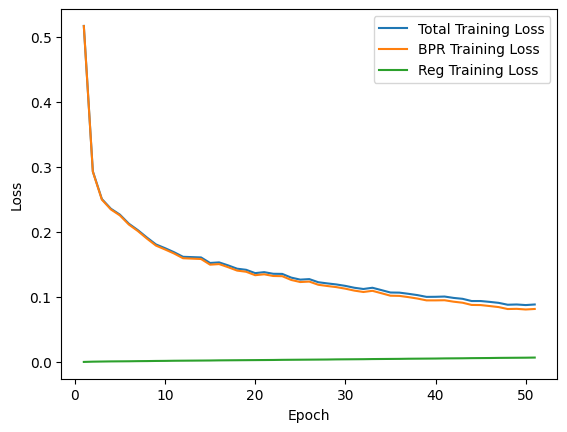

In [114]:
plt.plot(epoch_list, light_loss, label='Total Training Loss')
plt.plot(epoch_list, light_bpr, label='BPR Training Loss')
plt.plot(epoch_list, light_reg, label='Reg Training Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

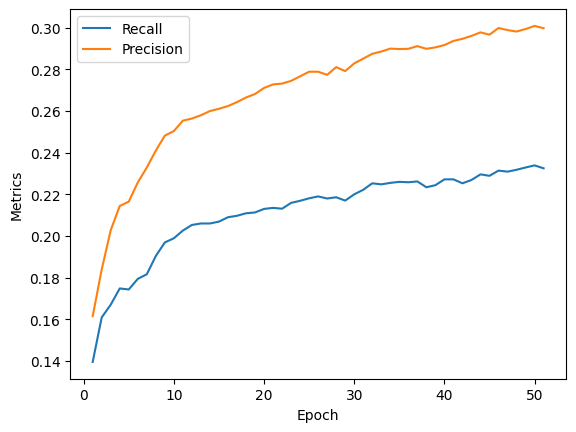

In [115]:
plt.plot(epoch_list, light_recall, label='Recall')
plt.plot(epoch_list, light_precision, label='Precision')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.legend()